In [1]:
%env LOGURU_LEVEL=INFO

env: LOGURU_LEVEL=INFO


In [2]:
import torch
from torch.nn import Module
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.nn import CrossEntropyLoss, Linear, Module, ReLU, Sequential
from torch.utils.data import DataLoader
from functools import partial

from smolai.trainer import Trainer
from smolai.callbacks.report import ReportMetricsWithLogger, RealTimeLoss, ReportEpochs, ReportMetricsWithLogger
from smolai.metrics import Accuracy, Loss
from smolai.callbacks.lr import LrFinder

In [3]:
train_ds = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = True,
    download = True,
    transform = transforms.ToTensor()                                 
)
train_dl = DataLoader(train_ds, batch_size=256, shuffle=True)
test_ds = torchvision.datasets.FashionMNIST(
    root = './data/FashionMNIST',
    train = False,
    download = True,
    transform = transforms.ToTensor()
)
test_dl = DataLoader(test_ds, batch_size=256, shuffle=False)

In [4]:
from smolai.layers import LayerNorm

In [5]:
class ConvBlock(Module):
    def __init__(self, c_in, c_out, activation=nn.ReLU, skip_connection=True, norm=LayerNorm, ks=3, stride=2):
        super().__init__()
        self.conv = nn.Conv2d(c_in, c_out, stride=stride, kernel_size=ks, padding=ks//2)]
        self.activation = activation() if activation else None
        self.norm = norm() if norm else None
        self.skip_connection = skip_connection
        
        
    def forward(self, x):
        x_orig = x
        x = self.conv(x)
        if self.activation:
            x = self.activation(x)
        if self.norm:
            x = self.norm(x)
        if self.skip_connection:
            x += x_orig
        return x

    
def get_simple_model():
    block = partial(ConvBlock, norm=None)
    return nn.Sequential(
        block(1, 8),
        block(8, 16),
        block(16, 32),
        block(32, 64),
        block(64, 10, activation=None, norm=None),
        nn.Flatten(),
    )

def get_norm_model():
    block = ConvBlock
    return nn.Sequential(
        block(1, 8),
        block(8, 16),
        block(16, 32),
        block(32, 64),
        block(64, 10, activation=None, norm=None),
        nn.Flatten(),
    )

Looking at the learning rates, it looks strange to begin with

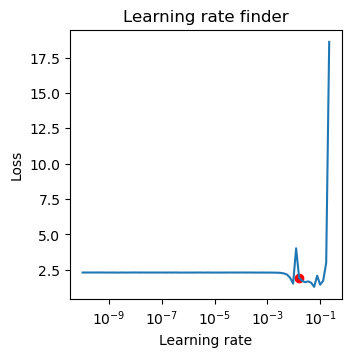

In [6]:
lrf = LrFinder()
trainer = Trainer(
    model=get_simple_model(),
    criterion=CrossEntropyLoss(),
    opt_func=torch.optim.AdamW,
    callbacks=[lrf, Loss],
).fit(train_dl=train_dl, lr=1e-10)
lrf.plot()

If we initialize using Kaiming, the learning rate curve looks much better.

In [7]:
from smolai.callbacks.weights import InitWeights

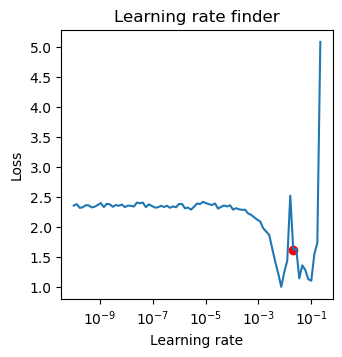

In [8]:
lrf = LrFinder()
trainer = Trainer(
    model=get_simple_model(),
    criterion=CrossEntropyLoss(),
    opt_func=torch.optim.AdamW,
    callbacks=[lrf, Loss, InitWeights],
).fit(train_dl=train_dl, lr=1e-10)
lrf.plot()

Better. Let's use `lr=1e-3`

2022-12-20 01:20:50.536 | INFO     | smolai.callbacks.report:epoch:17 - epoch 1/5...


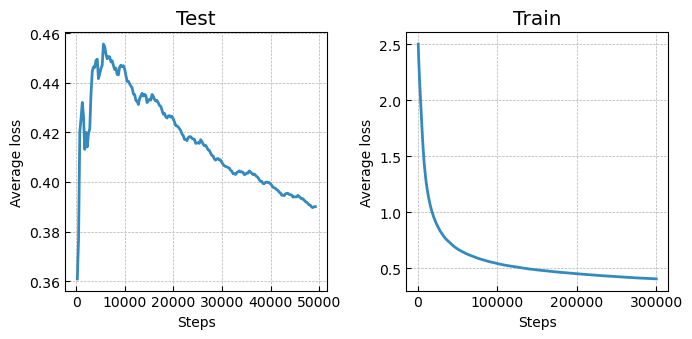

2022-12-20 01:21:21.053 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.63, accuracy: 0.78]
2022-12-20 01:21:21.054 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: 0.45, accuracy: 0.83]
2022-12-20 01:21:21.054 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 1/5 done
2022-12-20 01:21:21.056 | INFO     | smolai.callbacks.report:epoch:17 - epoch 2/5...
2022-12-20 01:21:52.527 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.51, accuracy: 0.82]
2022-12-20 01:21:52.528 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: 0.43, accuracy: 0.84]
2022-12-20 01:21:52.529 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 2/5 done
2022-12-20 01:21:52.530 | INFO     | smolai.callbacks.report:epoch:17 - epoch 3/5...
2022-12-20 01:22:23.507 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.46, accuracy: 0.83]
2022-12-20 01:22:23.508 | INFO     | smolai.c

In [10]:
trainer = Trainer(
    model=get_simple_model(),
    criterion=CrossEntropyLoss(),
    opt_func=torch.optim.AdamW,
    callbacks=[RealTimeLoss, Loss, Accuracy, InitWeights, ReportEpochs, ReportMetricsWithLogger],
).fit(
    train_dl=train_dl,
    test_dl=test_dl,
    lr=1e-3,
    n_epochs=5,
)

`85%` accurate. Can we do better with layer normalization?

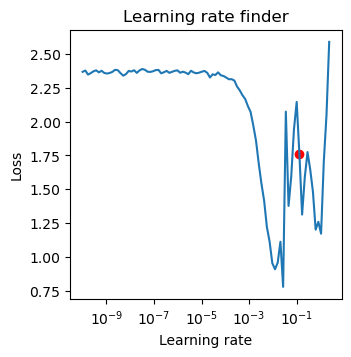

In [11]:
lrf = LrFinder()
trainer = Trainer(
    model=get_norm_model(),
    criterion=CrossEntropyLoss(),
    opt_func=torch.optim.AdamW,
    callbacks=[lrf, Loss],
).fit(train_dl=train_dl, lr=1e-10)
lrf.plot()

Looks stable. Let's push the LR to `1e-2`.

2022-12-20 01:23:28.565 | INFO     | smolai.callbacks.report:epoch:17 - epoch 1/5...


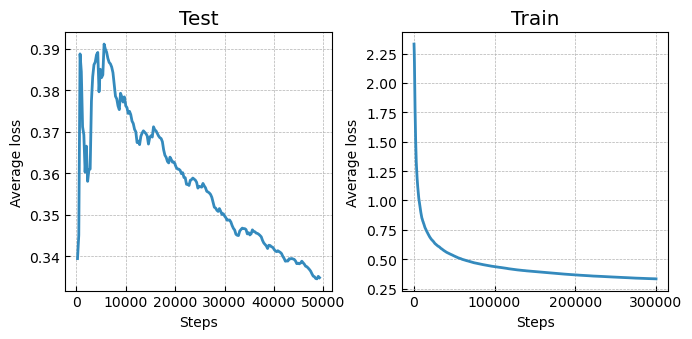

2022-12-20 01:24:01.750 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.50, accuracy: 0.82]
2022-12-20 01:24:01.751 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: 0.38, accuracy: 0.86]
2022-12-20 01:24:01.752 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 1/5 done
2022-12-20 01:24:01.753 | INFO     | smolai.callbacks.report:epoch:17 - epoch 2/5...
2022-12-20 01:24:35.930 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.42, accuracy: 0.85]
2022-12-20 01:24:35.931 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: 0.36, accuracy: 0.87]
2022-12-20 01:24:35.933 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 2/5 done
2022-12-20 01:24:35.934 | INFO     | smolai.callbacks.report:epoch:17 - epoch 3/5...
2022-12-20 01:25:10.986 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.38, accuracy: 0.86]
2022-12-20 01:25:10.987 | INFO     | smolai.c

In [12]:
trainer = Trainer(
    model=get_norm_model(),
    criterion=CrossEntropyLoss(),
    opt_func=torch.optim.AdamW,
    callbacks=[RealTimeLoss, Loss, Accuracy, ReportEpochs, ReportMetricsWithLogger],
).fit(
    train_dl=train_dl,
    test_dl=test_dl,
    lr=1e-2,
    n_epochs=5,
)

`87%`. Better! Can we beat this by tinkering with the learning rate scheduling?

In [13]:
from smolai.callbacks.scheduler import OneCycleScheduler

2022-12-20 01:26:20.190 | INFO     | smolai.callbacks.report:epoch:17 - epoch 1/5...


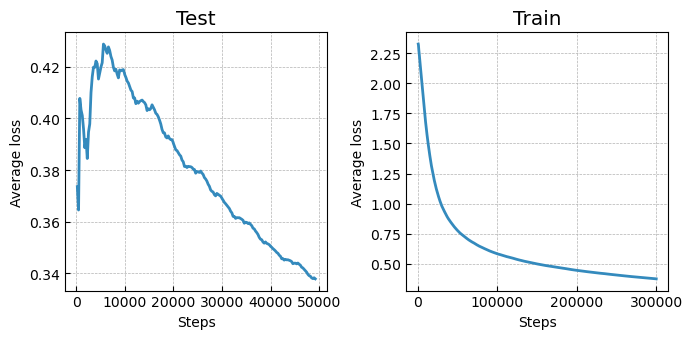

2022-12-20 01:26:55.763 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.72, accuracy: 0.77]
2022-12-20 01:26:55.764 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: 0.42, accuracy: 0.85]
2022-12-20 01:26:55.765 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 1/5 done
2022-12-20 01:26:55.766 | INFO     | smolai.callbacks.report:epoch:17 - epoch 2/5...
2022-12-20 01:27:32.453 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.54, accuracy: 0.82]
2022-12-20 01:27:32.454 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: 0.39, accuracy: 0.86]
2022-12-20 01:27:32.455 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 2/5 done
2022-12-20 01:27:32.456 | INFO     | smolai.callbacks.report:epoch:17 - epoch 3/5...
2022-12-20 01:28:08.345 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.46, accuracy: 0.84]
2022-12-20 01:28:08.346 | INFO     | smolai.c

In [14]:
trainer = Trainer(
    model=get_norm_model(),
    criterion=CrossEntropyLoss(),
    opt_func=torch.optim.AdamW,
    callbacks=[RealTimeLoss, Loss, Accuracy, ReportEpochs, ReportMetricsWithLogger, OneCycleScheduler],
).fit(
    train_dl=train_dl,
    test_dl=test_dl,
    lr=1e-2,
    n_epochs=5,
)

Throw it all together.

2022-12-20 01:29:19.823 | INFO     | smolai.callbacks.report:epoch:17 - epoch 1/5...


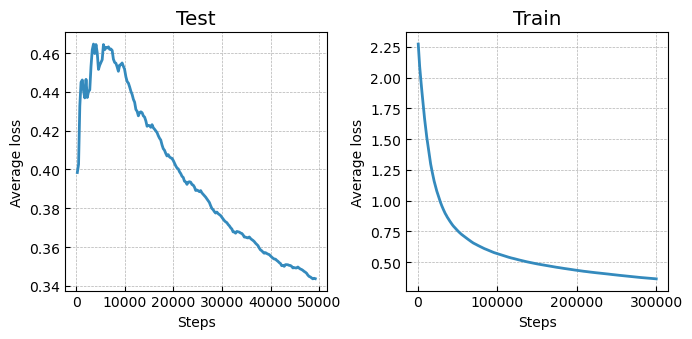

2022-12-20 01:29:52.647 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.70, accuracy: 0.76]
2022-12-20 01:29:52.648 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: 0.45, accuracy: 0.84]
2022-12-20 01:29:52.648 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 1/5 done
2022-12-20 01:29:52.650 | INFO     | smolai.callbacks.report:epoch:17 - epoch 2/5...
2022-12-20 01:30:27.267 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.53, accuracy: 0.81]
2022-12-20 01:30:27.268 | INFO     | smolai.callbacks.report:epoch:31 - metrics (test):     [loss: 0.40, accuracy: 0.85]
2022-12-20 01:30:27.269 | INFO     | smolai.callbacks.report:epoch:19 - ...epoch 2/5 done
2022-12-20 01:30:27.270 | INFO     | smolai.callbacks.report:epoch:17 - epoch 3/5...
2022-12-20 01:31:00.721 | INFO     | smolai.callbacks.report:epoch:30 - metrics (training): [loss: 0.45, accuracy: 0.84]
2022-12-20 01:31:00.722 | INFO     | smolai.c

In [15]:
trainer = Trainer(
    model=get_norm_model(),
    criterion=CrossEntropyLoss(),
    opt_func=torch.optim.AdamW,
    callbacks=[RealTimeLoss, Loss, Accuracy, ReportEpochs, ReportMetricsWithLogger, OneCycleScheduler, InitWeights],
).fit(
    train_dl=train_dl,
    test_dl=test_dl,
    lr=1e-2,
    n_epochs=5,
)

In [ ]:
def get_deeper_norm_model():
    block = ConvBlock
    return nn.Sequential(
        block(1, 8),
        block(8, 16),
        block(16, 32),
        block(32, 64),
        block(64, 10, activation=None, norm=None),
        nn.Flatten(),
    )